In [2]:
gdf = gpd.read_file('C:/Users/zheng/OneDrive - Louisiana State University/Documents/1 GSAPP/1 Colloqium 1/3 Politics/nyct2020_24c/nyct2020.shp')

In [3]:
gdf.head(3)

,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,GEOID,PUMA,Shape_Leng,Shape_Area,geometry
0,1,1,Manhattan,000100,1000100,None,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000100,4121,10833.043929,1.843005e+06,"MULTIPOLYGON (((972081.788 190733.467, 972184...."
1,2.01,1,Manhattan,000201,1000201,None,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000201,4103,4754.495247,9.723121e+05,"POLYGON ((988548.218 197770.375, 987978.808 19..."
2,6,1,Manhattan,000600,1000600,None,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000600,4103,6976.286215,2.582705e+06,"POLYGON ((986961.185 199553.643, 987206.139 19..."


In [4]:
import requests
import pandas as pd

def fetch_data_from_api(api_url, params):
    try:
        response = requests.get(api_url, params=params)
        response.raise_for_status()  # Raise an exception for HTTP errors
        return response.json()  # Convert response to JSON format
    except requests.exceptions.RequestException as e:
        print("Error fetching data:", e)
        return None

# API URL
api_url = "https://api.census.gov/data/2019/acs/acs5"

# Your API key
api_key = "b545b320d90ba4ae704fe87a2088c58c0a333bdb"  # Use your actual API key

# List of NYC county FIPS codes
# 005: Bronx
# 047: Brooklyn (Kings)
# 061: Manhattan (New York)
# 081: Queens
# 085: Staten Island (Richmond)
nyc_county_fips_codes = ["005", "047", "061", "081", "085"]

data_frames = []

# Fetch and Process Data for Each County
for county_code in nyc_county_fips_codes:
    # Query parameters for census block group-level data in each NYC borough
    params = {
        #columns identified, in order: household by type, Total pop., MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2019 INFLATION-ADJUSTED DOLLARS), SEX BY OCCUPATION FOR THE CIVILIAN EMPLOYED POPULATION 16 YEARS AND OVER, SEX BY WORK STATUS IN THE PAST 12 MONTHS BY USUAL HOURS WORKED PER WEEK IN THE PAST 12 MONTHS BY WEEKS WORKED IN THE PAST 12 MONTHS FOR THE POPULATION 65 YEARS AND OVER, POPULATION UNDER 18 YEARS BY AGE, PUBLIC ASSISTANCE INCOME OR FOOD STAMPS/SNAP IN THE PAST 12 MONTHS FOR HOUSEHOLDS
        "get": "NAME,B11012_001E,B01001_001E,B19013_001E,C24010_001E,B23026_001E,B09001_001E,B19058_002E",
        "for": "tract:*",
        "in": f"state:36 county:{county_code}",
        "key": api_key
    }
    
    # Fetch data for block groups
    data = fetch_data_from_api(api_url, params)
    
    if data:
        # pd.DataFrame(), pandas constructor for creating a DataFrame. It takes two arguments here: the data rows and the column headers.
        # 'data[1:]' skipping the header row b/c 'data[0]' usually contains the column headers
        df = pd.DataFrame(data[1:], columns=data[0])
        data_frames.append(df)

In [5]:
# Combine all DataFrames into one
df_nyc_block_groups = pd.concat(data_frames, ignore_index=True)
# By default, it concatenates along the vertical axis (i.e., rows)

print(df_nyc_block_groups)

                                                NAME B11012_001E B01001_001E  \
0           Census Tract 200, Bronx County, New York        1469        4711   
1        Census Tract 205.01, Bronx County, New York        2858        6976   
2        Census Tract 205.02, Bronx County, New York         926        2160   
3           Census Tract 209, Bronx County, New York        1732        4287   
4        Census Tract 210.01, Bronx County, New York        3841        8930   
...                                              ...         ...         ...   
2162  Census Tract 187.01, Richmond County, New York         652        1874   
2163  Census Tract 187.02, Richmond County, New York        2334        7947   
2164  Census Tract 189.01, Richmond County, New York        1841        5057   
2165     Census Tract 213, Richmond County, New York        1491        4681   
2166      Census Tract 11, Richmond County, New York        1157        3314   

     B19013_001E C24010_001E B23026_001

In [6]:
# Convert numeric columns to appropriate data types
df_nyc_block_groups['totalhousehold'] = pd.to_numeric(df_nyc_block_groups['B11012_001E'], errors='coerce')
df_nyc_block_groups['totalpop'] = pd.to_numeric(df_nyc_block_groups['B01001_001E'], errors='coerce')
df_nyc_block_groups['employedpop_16andover'] = pd.to_numeric(df_nyc_block_groups['C24010_001E'], errors='coerce')
df_nyc_block_groups['employedpop_65andover'] = pd.to_numeric(df_nyc_block_groups['B23026_001E'], errors='coerce')
df_nyc_block_groups['under18pop'] = pd.to_numeric(df_nyc_block_groups['B09001_001E'], errors='coerce')
df_nyc_block_groups['publicassistance'] = pd.to_numeric(df_nyc_block_groups['B19058_002E'], errors='coerce')

# Remove rows where employed population is zero (to avoid 100% unemployment cases)
df_nyc_block_groups = df_nyc_block_groups[df_nyc_block_groups['employedpop_16andover'] > 0]

In [7]:
# Calculate the percentage of employed population (%) (employment-population ratio typical 55% to 60%)
df_nyc_block_groups['percentage_employed_16andover'] = (df_nyc_block_groups['employedpop_16andover'] / df_nyc_block_groups['totalpop']).astype(float) * 100
df_nyc_block_groups['percentage_employed_65andover'] = (df_nyc_block_groups['employedpop_65andover'] / df_nyc_block_groups['totalpop']).astype(float) * 100
df_nyc_block_groups['percentage_under18'] = (df_nyc_block_groups['under18pop'] / df_nyc_block_groups['totalpop']).astype(float) * 100
df_nyc_block_groups['percentage_publicassistance'] = (df_nyc_block_groups['publicassistance'] / df_nyc_block_groups['totalhousehold']).astype(float) * 100

# Calculate the percentage of the unemployed population
df_nyc_block_groups['percentage_unemployed_16andover'] = 100 - df_nyc_block_groups['percentage_employed_16andover']

# Display the updated DataFrame
df_nyc_block_groups.head()

,NAME,B11012_001E,B01001_001E,B19013_001E,C24010_001E,B23026_001E,B09001_001E,B19058_002E,state,county,...,totalpop,employedpop_16andover,employedpop_65andover,under18pop,publicassistance,percentage_employed_16andover,percentage_employed_65andover,percentage_under18,percentage_publicassistance,percentage_unemployed_16andover
0,"Census Tract 200, Bronx County, New York",1469,4711,40184,1934,351,1401,485,36,005,...,4711,1934,351,1401,485,41.052855,7.450647,29.738909,33.015657,58.947145
1,"Census Tract 205.01, Bronx County, New York",2858,6976,17601,2333,826,1663,1609,36,005,...,6976,2333,826,1663,1609,33.443234,11.840596,23.838876,56.298111,66.556766
2,"Census Tract 205.02, Bronx County, New York",926,2160,18919,922,426,423,543,36,005,...,2160,922,426,423,543,42.685185,19.722222,19.583333,58.639309,57.314815
3,"Census Tract 209, Bronx County, New York",1732,4287,31190,1755,445,990,797,36,005,...,4287,1755,445,990,797,40.937719,10.380219,23.093072,46.016166,59.062281
4,"Census Tract 210.01, Bronx County, New York",3841,8930,54076,4606,1134,1745,912,36,005,...,8930,4606,1134,1745,912,51.578947,12.698768,19.540873,23.743817,48.421053


In [8]:
# Save the updated DataFrame to a new CSV file
output_file_path = 'updated_nyc_block_groups.csv'
df_nyc_block_groups.to_csv(output_file_path, index=False)

In [9]:
# Data Cleaning: Replaces placeholder values with 'nan'
df_nyc_block_groups.replace(-666666666.0, np.nan, inplace=True)

In [10]:
# create a new column called 'region_id' in the previous DataFrame 'df_nyc_block_groups'; a concatenation of the values in the existing columns state, county, and tract.
df_nyc_block_groups['region_id'] = df_nyc_block_groups['state'] + df_nyc_block_groups['county'] + df_nyc_block_groups['tract']

In [11]:
df_nyc_block_groups.head(3)

,NAME,B11012_001E,B01001_001E,B19013_001E,C24010_001E,B23026_001E,B09001_001E,B19058_002E,state,county,...,employedpop_16andover,employedpop_65andover,under18pop,publicassistance,percentage_employed_16andover,percentage_employed_65andover,percentage_under18,percentage_publicassistance,percentage_unemployed_16andover,region_id
0,"Census Tract 200, Bronx County, New York",1469,4711,40184,1934,351,1401,485,36,005,...,1934,351,1401,485,41.052855,7.450647,29.738909,33.015657,58.947145,36005020000
1,"Census Tract 205.01, Bronx County, New York",2858,6976,17601,2333,826,1663,1609,36,005,...,2333,826,1663,1609,33.443234,11.840596,23.838876,56.298111,66.556766,36005020501
2,"Census Tract 205.02, Bronx County, New York",926,2160,18919,922,426,423,543,36,005,...,922,426,423,543,42.685185,19.722222,19.583333,58.639309,57.314815,36005020502


In [12]:
# Merge DataFrames
merged_gdf = gdf.merge(df_nyc_block_groups, left_on='GEOID', right_on='region_id', how='left')

In [13]:
merged_gdf.head(3)

,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,...,employedpop_16andover,employedpop_65andover,under18pop,publicassistance,percentage_employed_16andover,percentage_employed_65andover,percentage_under18,percentage_publicassistance,percentage_unemployed_16andover,region_id
0,1,1,Manhattan,000100,1000100,None,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.01,1,Manhattan,000201,1000201,None,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),...,1063.0,443.0,630.0,617.0,38.654545,16.109091,22.909091,56.501832,61.345455,36061000201
2,6,1,Manhattan,000600,1000600,None,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),...,2922.0,3324.0,1253.0,2368.0,29.701159,33.787355,12.736329,58.483576,70.298841,36061000600


In [14]:
# convert the coordinate reference system (CRS) of a GeoDataFrame (merged_gdf) to the EPSG:4326 CRS
merged_gdf_2 = merged_gdf.to_crs(epsg=4326)

<Figure size 1000x1000 with 0 Axes>

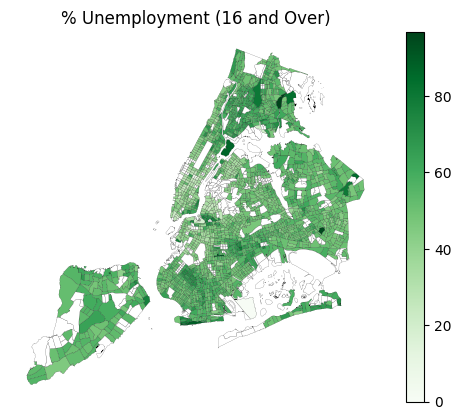

<Figure size 1000x1000 with 0 Axes>

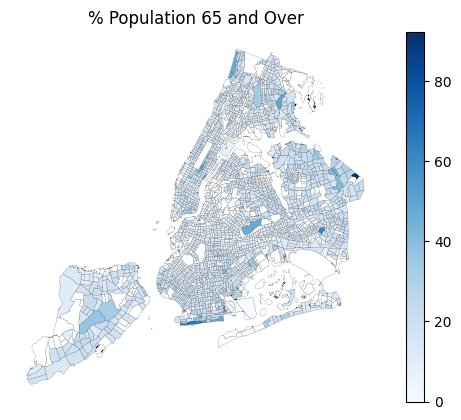

<Figure size 1000x1000 with 0 Axes>

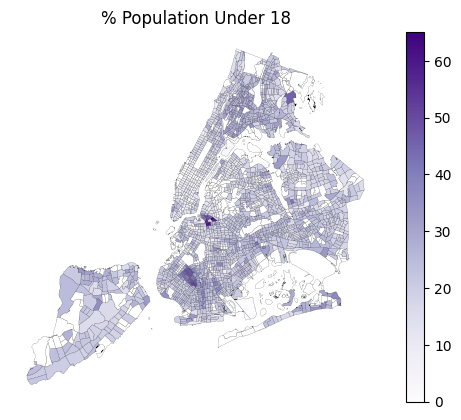

<Figure size 1000x1000 with 0 Axes>

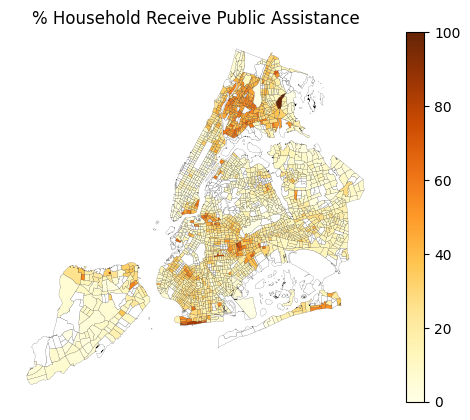

In [15]:
def plot_choropleth(gdf, column, title, cmap='YlGnBu', boundaries=None, colors=None):
    plt.figure(figsize=(10, 10))  # Set the size of the figure

    # Create a BoundaryNorm and ListedColormap if boundaries and colors are provided
    if boundaries and colors:
        norm = BoundaryNorm(boundaries, ncolors=len(colors), clip=True)
        cmap = ListedColormap(colors)
    else:
        norm = plt.Normalize(vmin=gdf[column].min(), vmax=gdf[column].max())
    
    # Plot the choropleth map with handling for missing values
    ax = gdf.plot(column=column, cmap=cmap, linewidth=0.1, edgecolor='black', legend=True, 
                  missing_kwds={
                      "color": "white",  # Set the color for missing values to white
                      "edgecolor": "black",
                  })

    # Add title
    plt.title(title)

    # Hide the axes
    plt.axis('off')

    # Show the plot
    plt.show()

# Define color maps for each attribute
color_maps = {
    'percentage_unemployed_16andover': 'Greens',
    'percentage_employed_65andover': 'Blues', 
    'percentage_under18': 'Purples',
    'percentage_publicassistance': 'YlOrBr'
}

# Define titles for each attribute
titles = {
    'percentage_unemployed_16andover': '% Unemployment (16 and Over)',
    'percentage_employed_65andover': '% Population 65 and Over', 
    'percentage_under18': '% Population Under 18',
    'percentage_publicassistance': '% Household Receive Public Assistance'
}


# Plot maps for each attribute with specific colors and titles
for column, title in titles.items():
    plot_choropleth(merged_gdf_2, column, title, cmap=color_maps[column])

In [16]:
# Calculate the composite vulnerability index
merged_gdf_2['composite_vulnerability_index'] = merged_gdf_2[[
    'percentage_employed_65andover', 
    'percentage_under18', 
    'percentage_publicassistance', 
    'percentage_unemployed_16andover'
]].mean(axis=1)

# Verify that the new column is added
print(merged_gdf_2[['composite_vulnerability_index']].head())

   composite_vulnerability_index
0                            NaN
1                      39.216367
2                      43.826525
3                      22.331655
4                      29.366800


In [17]:
# Function to plot the choropleth map
def plot_choropleth(gdf, column, title, cmap='YlGnBu', boundaries=None, colors=None):
    plt.figure(figsize=(10, 10))  # Set the size of the figure

    # Create a BoundaryNorm and ListedColormap if boundaries and colors are provided
    if boundaries and colors:
        norm = BoundaryNorm(boundaries, ncolors=len(colors), clip=True)
        cmap = ListedColormap(colors)
    else:
        norm = plt.Normalize(vmin=gdf[column].min(), vmax=gdf[column].max())
    
    # Plot the choropleth map with handling for missing values
    ax = gdf.plot(column=column, cmap=cmap, linewidth=0.1, edgecolor='black', legend=True, 
        missing_kwds={
            "color": "white",  # Set the color for missing values to white
            "edgecolor": "black",
    })

    # Add title
    plt.title(title)

    # Hide the axes
    plt.axis('off')

    # Show the plot
    plt.show()

# Plot the composite vulnerability index
plot_choropleth(merged_gdf, 'composite_vulnerability_index', 'Composite Vulnerability Index (%)')

KeyError: 'composite_vulnerability_index'

<Figure size 1000x1000 with 0 Axes>

In [ ]:
merged_gdf_2.head(3)

,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,...,employedpop_65andover,under18pop,publicassistance,percentage_employed_16andover,percentage_employed_65andover,percentage_under18,percentage_publicassistance,percentage_unemployed_16andover,region_id,composite_vulnerability_index
0,1,1,Manhattan,000100,1000100,None,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.01,1,Manhattan,000201,1000201,None,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),...,443.0,630.0,617.0,38.654545,16.109091,22.909091,56.501832,61.345455,36061000201,39.216367
2,6,1,Manhattan,000600,1000600,None,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),...,3324.0,1253.0,2368.0,29.701159,33.787355,12.736329,58.483576,70.298841,36061000600,43.826525


In [19]:
# Function to generate folium maps and save them as HTML
def generate_folium_map(gdf, column, title, colors, boundaries, output_html):
    # Replace None values with a default value
    gdf[column] = gdf[column].fillna(0)

    m = folium.Map(location=[40.7128, -74.0060], zoom_start=10, tiles='CartoDB dark_matter')  # Centered on New York City with CartoDB Dark Matter basemap
    
    # Create a colormap
    colormap = folium.LinearColormap(colors=colors, vmin=boundaries[0], vmax=boundaries[-1])
    colormap.caption = title
    
    # Add GeoJson to the map
    folium.GeoJson(
        gdf,
        style_function=lambda feature: {
            'fillColor': colormap(feature['properties'][column]),
            'color': 'black',
            'weight': 0.2,
            'fillOpacity': 0.7,
        },
        tooltip=folium.GeoJsonTooltip(fields=[column], aliases=[title])
    ).add_to(m)
    
    # Add colormap to the map
    m.add_child(colormap)
    
    # Save map to HTML
    m.save(output_html)

# Define color maps and boundaries for each attribute
attribute_styles = {
    'percentage_unemployed_16andover': {
        'title': "% Unemployment (16 and Over)",
        'colors': [(1, 1, 1, 0), '#f7fbff', '#6baed6', '#2171b5', '#08306b'],  # Light blue to dark blue
        'boundaries': [0, 20, 40, 60, 80]
    },
    'percentage_employed_65andover': {
        'title': "% Population 65 and Over",
        'colors': [(1, 1, 1, 0), '#ffffe5', '#feb24c', '#fd8d3c', '#e31a1c'],  # Light yellow to red
        'boundaries': [0, 15, 30, 45, 60]
    },
    'percentage_under18': {
        'title': "% Population Under 18",
        'colors': [(1, 1, 1, 0), '#f7f4f9', '#e7e1ef', '#c994c7', '#dd1c77'],  # Light purple to purple
        'boundaries': [0, 20, 40, 60, 80]
    },
    'percentage_publicassistance': {
        'title': "% Population Receive Public Assistance",
        'colors': [(1, 1, 1, 0), '#f7f4f9', '#d4b9da', '#c994c7', '#df65b0'],  # Light purple to pink
        'boundaries': [0, 25, 50, 75, 100]
    },
    'composite_vulnerability_index': {
        'title': "Composite Vulnerability Index (%)",
        'colors': [(1, 1, 1, 0), '#fff7ec', '#fee8c8', '#fdbb84', '#e34a33'],  # Light orange to red
        'boundaries': [0, 15, 30, 45, 60]
    }
}

# Generate maps for each attribute with specific colors
for column, style in attribute_styles.items():
    generate_folium_map(merged_gdf_2, column, style['title'], style['colors'], style['boundaries'], f'{column}.html')

# # Normalize each attribute
# for column in attributes.keys():
#     merged_gdf_2[column + '_norm'] = (merged_gdf_2[column] - merged_gdf_2[column].min()) / (merged_gdf_2[column].max() - merged_gdf_2[column].min())

In [20]:
#export as geojson

def generate_folium_map(gdf, column, title, colors, boundaries, output_html, output_geojson):
    # Replace None values with a default value
    gdf[column] = gdf[column].fillna(0)

    m = folium.Map(location=[40.7128, -74.0060], zoom_start=10, tiles='CartoDB dark_matter')
    
    # Create a colormap
    colormap = folium.LinearColormap(colors=colors, vmin=boundaries[0], vmax=boundaries[-1])
    colormap.caption = title
    
    # Define GeoJson layer
    geojson_layer = folium.GeoJson(
        gdf,
        style_function=lambda feature: {
            'fillColor': colormap(feature['properties'][column]),
            'color': 'black',
            'weight': 0.2,
            'fillOpacity': 0.7
        },
        tooltip=folium.GeoJsonTooltip(fields=[column], aliases=[title])
    ).add_to(m)
    
    # Add colormap to the map
    m.add_child(colormap)
    
    # Save map to HTML
    m.save(output_html)
    
    # Save GeoDataFrame to GeoJSON
    gdf.to_file(output_geojson, driver='GeoJSON')

# Example usage:
for column, style in attribute_styles.items():
    generate_folium_map(
        merged_gdf_2, 
        column, 
        style['title'], 
        style['colors'], 
        style['boundaries'], 
        f'{column}.html',
        f'{column}.geojson'
    )


In [ ]:
print(merged_gdf_2.columns)

Index(['CTLabel', 'BoroCode', 'BoroName', 'CT2020', 'BoroCT2020', 'CDEligibil',
       'NTAName', 'NTA2020', 'CDTA2020', 'CDTANAME', 'GEOID', 'PUMA',
       'Shape_Leng', 'Shape_Area', 'geometry', 'NAME', 'B11012_001E',
       'B01001_001E', 'B19013_001E', 'C24010_001E', 'B23026_001E',
       'B09001_001E', 'B19058_002E', 'state', 'county', 'tract',
       'totalhousehold', 'totalpop', 'employedpop_16andover',
       'employedpop_65andover', 'under18pop', 'publicassistance',
       'percentage_employed_16andover', 'percentage_employed_65andover',
       'percentage_under18', 'percentage_publicassistance',
       'percentage_unemployed_16andover', 'region_id',
       'composite_vulnerability_index'],
      dtype='object')


In [ ]:
# one entry for each unique neighborhood name found in the data, where '.unique()' find all unique values in the NTAName column
unique_nta_names = merged_gdf_2['NTAName'].unique()
print(unique_nta_names)

['The Battery-Governors Island-Ellis Island-Liberty Island'
 'Chinatown-Two Bridges' 'Lower East Side' 'East Village'
 'Tribeca-Civic Center' 'SoHo-Little Italy-Hudson Square'
 'Midtown South-Flatiron-Union Square' 'Greenwich Village' 'West Village'
 'Gramercy' 'Murray Hill-Kips Bay' 'Chelsea-Hudson Yards'
 'Midtown-Times Square' 'East Midtown-Turtle Bay'
 'Upper East Side-Carnegie Hill'
 'Upper East Side-Lenox Hill-Roosevelt Island' "Hell's Kitchen"
 'Upper East Side-Yorkville' 'Upper West Side-Lincoln Square'
 'East Harlem (South)' 'Upper West Side (Central)' 'East Harlem (North)'
 'Harlem (South)' 'Upper West Side-Manhattan Valley' 'Morningside Heights'
 'Harlem (North)' 'Manhattanville-West Harlem'
 'Hamilton Heights-Sugar Hill' 'Washington Heights (South)'
 'Washington Heights (North)' 'Inwood' 'Soundview-Clason Point'
 'North & South Brother Islands' 'Mott Haven-Port Morris'
 'Castle Hill-Unionport' 'Soundview-Bruckner-Bronx River'
 'Yankee Stadium-Macombs Dam Park' 'Melrose' 'Lo

In [ ]:
filtered_gdf = merged_gdf_2[merged_gdf_2['NTAName'] == 'Ocean Hill']


In [ ]:
filtered_gdf.head(10)

,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,...,employedpop_65andover,under18pop,publicassistance,percentage_employed_16andover,percentage_employed_65andover,percentage_under18,percentage_publicassistance,percentage_unemployed_16andover,region_id,composite_vulnerability_index
1407,301,3,Brooklyn,030100,3030100,None,Ocean Hill,BK1601,BK16,BK16 Ocean Hill-Brownsville (CD 16 Approximation),...,376.0,737.0,270.0,39.757003,12.689841,24.873439,25.186567,60.242997,36047030100,30.748211
1409,303,3,Brooklyn,030300,3030300,None,Ocean Hill,BK1601,BK16,BK16 Ocean Hill-Brownsville (CD 16 Approximation),...,447.0,1304.0,688.0,39.255189,9.096459,26.536427,35.610766,60.744811,36047030300,32.997116
1461,361,3,Brooklyn,036100,3036100,None,Ocean Hill,BK1601,BK16,BK16 Ocean Hill-Brownsville (CD 16 Approximation),...,567.0,614.0,541.0,30.462863,20.344456,22.030858,46.961806,69.537137,36047036100,39.718564
1463,363,3,Brooklyn,036300,3036300,None,Ocean Hill,BK1601,BK16,BK16 Ocean Hill-Brownsville (CD 16 Approximation),...,658.0,1583.0,706.0,38.164155,13.045202,31.383822,37.177462,61.835845,36047036300,35.860583
1465,365.01,3,Brooklyn,036501,3036501,None,Ocean Hill,BK1601,BK16,BK16 Ocean Hill-Brownsville (CD 16 Approximation),...,405.0,891.0,317.0,38.718174,11.852502,26.075505,24.459877,61.281826,36047036501,30.917427
1466,369,3,Brooklyn,036900,3036900,None,Ocean Hill,BK1601,BK16,BK16 Ocean Hill-Brownsville (CD 16 Approximation),...,394.0,1520.0,761.0,42.630033,6.808364,26.265768,35.117674,57.369967,36047036900,31.390443
1468,371,3,Brooklyn,037100,3037100,None,Ocean Hill,BK1601,BK16,BK16 Ocean Hill-Brownsville (CD 16 Approximation),...,375.0,1240.0,293.0,47.166207,7.960093,26.321376,17.034884,52.833793,36047037100,26.037536
1469,373,3,Brooklyn,037300,3037300,None,Ocean Hill,BK1601,BK16,BK16 Ocean Hill-Brownsville (CD 16 Approximation),...,358.0,1138.0,461.0,51.761034,7.980383,25.367811,27.022274,48.238966,36047037300,27.152359
2000,365.02,3,Brooklyn,036502,3036502,None,Ocean Hill,BK1601,BK16,BK16 Ocean Hill-Brownsville (CD 16 Approximation),...,96.0,378.0,155.0,38.869258,6.784452,26.713781,30.451866,61.130742,36047036502,31.270210
2057,367,3,Brooklyn,036700,3036700,None,Ocean Hill,BK1601,BK16,BK16 Ocean Hill-Brownsville (CD 16 Approximation),...,77.0,214.0,104.0,55.347385,6.010929,16.705699,20.194175,44.652615,36047036700,21.890854


<Axes: >

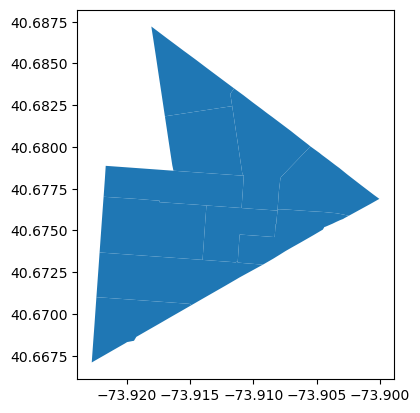

In [ ]:
filtered_gdf.plot()

In [ ]:
filtered_gdf.to_file("OceanHillTest_6.geojson")

In [ ]:
neighborhood = "nyct2020_24c/nyct2020.shp"
neighborhood_gdf = gpd.read_file(neighborhood)
neighborhood_gdf.head(3)

,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,GEOID,PUMA,Shape_Leng,Shape_Area,geometry
0,1,1,Manhattan,000100,1000100,None,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000100,4121,10833.043929,1.843005e+06,"MULTIPOLYGON (((972081.788 190733.467, 972184...."
1,2.01,1,Manhattan,000201,1000201,None,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000201,4103,4754.495247,9.723121e+05,"POLYGON ((988548.218 197770.375, 987978.808 19..."
2,6,1,Manhattan,000600,1000600,None,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000600,4103,6976.286215,2.582705e+06,"POLYGON ((986961.185 199553.643, 987206.139 19..."


In [ ]:
neighborhood_gdf = neighborhood_gdf.to_crs("EPSG:4326")

In [ ]:
neighborhood_gdf.head(3)

,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,GEOID,PUMA,Shape_Leng,Shape_Area,geometry
0,1,1,Manhattan,000100,1000100,None,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000100,4121,10833.043929,1.843005e+06,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."
1,2.01,1,Manhattan,000201,1000201,None,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000201,4103,4754.495247,9.723121e+05,"POLYGON ((-73.98450 40.70951, -73.98655 40.709..."
2,6,1,Manhattan,000600,1000600,None,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000600,4103,6976.286215,2.582705e+06,"POLYGON ((-73.99022 40.71440, -73.98934 40.714..."


In [ ]:
import pandas as pd
import geopandas as gpd

# Assuming neighborhood_gdf and merged_gdf_2 are your GeoDataFrames

# Calculate sums and averages for desired columns in merged_gdf_2
sum_columns = ['B19013_001E', 'C24010_001E', 'B23026_001E', 'B09001_001E', 'B19058_001E']
average_columns = ['B19013_001E', 'B19058_001E']

merged_gdf_2_sums = merged_gdf_2.groupby('NTAName')[sum_columns].sum().reset_index()
merged_gdf_2_averages = merged_gdf_2.groupby('NTAName')[average_columns].mean().reset_index()

# Merge sums and averages back into neighborhood_gdf
neighborhood_gdf = pd.merge(neighborhood_gdf, merged_gdf_2_sums, how='left', on='NTAName')
neighborhood_gdf = pd.merge(neighborhood_gdf, merged_gdf_2_averages, how='left', on='NTAName')

# Calculate averages for 'B19013_001E' and 'B25064_001E' in neighborhood_gdf
neighborhood_gdf['B19013_001E'] = (neighborhood_gdf['B19013_001E_x'] + neighborhood_gdf['B19013_001E_y']) / 2
neighborhood_gdf['B19058_001E'] = (neighborhood_gdf['B19058_001E_x'] + neighborhood_gdf['B19058_001E_y']) / 2

# Drop redundant columns
neighborhood_gdf.drop(columns=['B19013_001E_x', 'B19013_001E_y', 'B19058_001E_x', 'B19058_001E_y'], inplace=True)


In [ ]:
neighborhood_gdf.head(3)

,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,GEOID,PUMA,Shape_Leng,Shape_Area,geometry,C24010_001E,B23026_001E,B09001_001E,B19013_001E,B19058_001E
0,1,1,Manhattan,000100,1000100,None,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000100,4121,10833.043929,1.843005e+06,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",0.0,0.0,0.0,NaN,0.000000
1,2.01,1,Manhattan,000201,1000201,None,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000201,4103,4754.495247,9.723121e+05,"POLYGON ((-73.98450 40.70951, -73.98655 40.709...",13821.0,10007.0,4766.0,122072.416667,8486.333333
2,6,1,Manhattan,000600,1000600,None,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000600,4103,6976.286215,2.582705e+06,"POLYGON ((-73.99022 40.71440, -73.98934 40.714...",13821.0,10007.0,4766.0,122072.416667,8486.333333


In [ ]:
print(neighborhood_gdf.columns)

Index(['CTLabel', 'BoroCode', 'BoroName', 'CT2020', 'BoroCT2020', 'CDEligibil',
       'NTAName', 'NTA2020', 'CDTA2020', 'CDTANAME', 'GEOID', 'PUMA',
       'Shape_Leng', 'Shape_Area', 'geometry', 'C24010_001E', 'B23026_001E',
       'B09001_001E', 'B19013_001E', 'B19058_001E'],
      dtype='object')


In [ ]:
print(neighborhood_gdf)

     CTLabel BoroCode       BoroName  CT2020 BoroCT2020 CDEligibil  \
0          1        1      Manhattan  000100    1000100       None   
1       2.01        1      Manhattan  000201    1000201       None   
2          6        1      Manhattan  000600    1000600       None   
3      14.01        1      Manhattan  001401    1001401       None   
4      14.02        1      Manhattan  001402    1001402       None   
...      ...      ...            ...     ...        ...        ...   
2320     176        5  Staten Island  017600    5017600       None   
2321  228.02        5  Staten Island  022802    5022802       None   
2322  291.02        5  Staten Island  029102    5029102       None   
2323     161        2          Bronx  016100    2016100       None   
2324     163        2          Bronx  016300    2016300       None   

                                                NTAName NTA2020 CDTA2020  \
0     The Battery-Governors Island-Ellis Island-Libe...  MN0191     MN01   
1      

In [ ]:
neighborhood_gdf.drop(columns=['C24010_001E', 'B23026_001E', 'B09001_001E', 'B19013_001E', 'B19058_001E'], inplace=True)

KeyError: "['C24010_001E', 'B23026_001E', 'B09001_001E', 'B19013_001E', 'B19058_001E'] not found in axis"

In [ ]:
print(neighborhood_gdf)

     CTLabel BoroCode       BoroName  CT2020 BoroCT2020 CDEligibil  \
0          1        1      Manhattan  000100    1000100       None   
1       2.01        1      Manhattan  000201    1000201       None   
2          6        1      Manhattan  000600    1000600       None   
3      14.01        1      Manhattan  001401    1001401       None   
4      14.02        1      Manhattan  001402    1001402       None   
...      ...      ...            ...     ...        ...        ...   
2320     176        5  Staten Island  017600    5017600       None   
2321  228.02        5  Staten Island  022802    5022802       None   
2322  291.02        5  Staten Island  029102    5029102       None   
2323     161        2          Bronx  016100    2016100       None   
2324     163        2          Bronx  016300    2016300       None   

                                                NTAName NTA2020 CDTA2020  \
0     The Battery-Governors Island-Ellis Island-Libe...  MN0191     MN01   
1      

<Axes: >

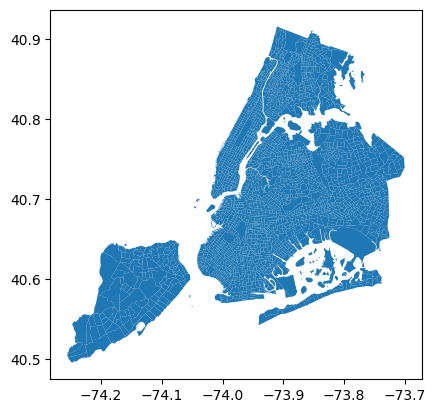

In [ ]:
neighborhood_gdf.plot()

In [ ]:
# Assuming you have a GeoDataFrame called 'gdf' and you want to rename multiple columns at once
column_mapping = {
    'B19013_001E_x': 'averagemedianincome',
    'C24010_001E_x': '16-64 employed gender',
    'B23026_001E': '>65 employed gender',
    'B09001_001': '<18 population',
    'B19058_001E': 'food stamp/snap (houeholds)',

    # Add more column mappings as needed
}

neighborhood_gdf.rename(columns=column_mapping, inplace=True)

In [ ]:
neighborhood_gdf.head(3)

,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,GEOID,PUMA,Shape_Leng,Shape_Area,geometry
0,1,1,Manhattan,000100,1000100,None,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000100,4121,10833.043929,1.843005e+06,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."
1,2.01,1,Manhattan,000201,1000201,None,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000201,4103,4754.495247,9.723121e+05,"POLYGON ((-73.98450 40.70951, -73.98655 40.709..."
2,6,1,Manhattan,000600,1000600,None,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000600,4103,6976.286215,2.582705e+06,"POLYGON ((-73.99022 40.71440, -73.98934 40.714..."


In [ ]:
neighborhood_gdf.to_file("neighborhoods2_f.geojson")